In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as ks
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras import layers
import os
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import RMSprop

In [2]:
class MetricsMicro(Callback):
    
    def set_model(self, model):
        self.model = model
        self.val_f1s  = []
        self.val_recalls = []
        self.val_preceisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(
            self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_preceisions.append(_val_precision)
        print(' val_f1_micro: %f | val_precision_micro: %f | val_recall_micro: %f'%
             (_val_f1, _val_precision, _val_recall))

In [2]:
train_data = pd.read_csv('D:\\Machine Learning\\Datasets\\EmoContext\\train.txt',
                        sep='\t', index_col='id')
X = train_data.iloc[:,:-1]
y = train_data.iloc[:,-1]

In [3]:
full_conv = X[['turn1', 'turn2', 'turn3']].apply(lambda x: ' '.join(x), axis=1)

In [4]:
tokenizer = TweetTokenizer()
word_counts = full_conv.apply(lambda row: len(tokenizer.tokenize(row)))

In [5]:
print('word mean ', word_counts.mean())
print('word std ', word_counts.std())

word mean  15.134084880636605
word std  6.549633644470246


In [11]:
word_counts.max()

159

In [12]:
word_counts.min()

3

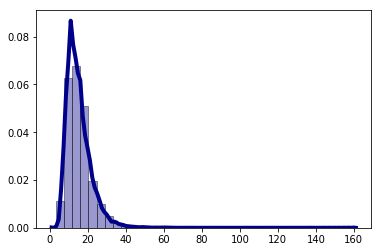

In [15]:
sns.distplot(word_counts, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.show()

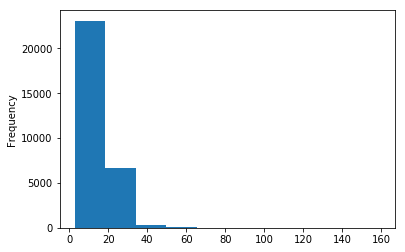

In [13]:
word_counts.plot.hist()
plt.show()

In [8]:
type(full_conv.apply(lambda x: tokenizer.tokenize(x.lower())))

pandas.core.series.Series

In [10]:
unique_tokens = set()

In [11]:
full_conv.apply(lambda x: unique_tokens.update(tokenizer.tokenize(x)))
len(unique_tokens)

19625

In [27]:
maxlen = 20
max_words = 5000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(full_conv)
train_seq = tokenizer.texts_to_sequences(full_conv)

In [28]:
x_train = pad_sequences(train_seq, maxlen=maxlen)

In [31]:
glove_dir = r'D:\Machine Learning\Embeddings\glove.twitter.27B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.twitter.27B.50d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
    

Found 1193514 word vectors.


In [32]:
embedding_dim = 50

word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [43]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.GRU(32))
model.add(layers.Dense(4, activation='softmax'))

In [44]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [71]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

In [63]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
encoder = LabelBinarizer()
y_train  = encoder.fit_transform(y)

In [73]:
callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/30
24128/24128 [==============================] - 8s 331us/step - loss: 0.4957 - acc: 0.8194 - val_loss: 0.5406 - val_acc: 0.8070
 val_f1_micro: 0.805166 | val_precision_micro: 0.837543 | val_recall_micro: 0.775199
Epoch 2/30
24128/24128 [==============================] - 7s 293us/step - loss: 0.4869 - acc: 0.8231 - val_loss: 0.5325 - val_acc: 0.8085
 val_f1_micro: 0.805748 | val_precision_micro: 0.832303 | val_recall_micro: 0.780836
Epoch 3/30
24128/24128 [==============================] - 7s 309us/step - loss: 0.4774 - acc: 0.8276 - val_loss: 0.5365 - val_acc: 0.8097
 val_f1_micro: 0.806860 | val_precision_micro: 0.840244 | val_recall_micro: 0.776028
Epoch 4/30
24128/24128 [==============================] - 7s 301us/step - loss: 0.4689 - acc: 0.8306 - val_loss: 0.5256 - val_acc: 0.8142
 val_f1_micro: 0.811005 | val_precision_micro: 0.836742 | val_recall_micro: 0.786804
Epoch 5/30
24128/24128 [==============================] - 7

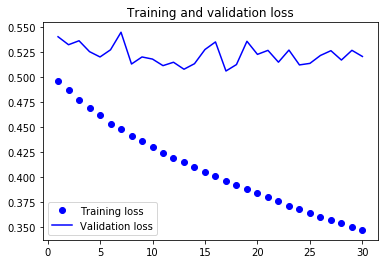

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [84]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [86]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

In [87]:
callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/30
24128/24128 [==============================] - 8s 343us/step - loss: 1.0111 - acc: 0.5963 - val_loss: 0.8178 - val_acc: 0.6852
 val_f1_micro: 0.663857 | val_precision_micro: 0.762971 | val_recall_micro: 0.587533
Epoch 2/30
24128/24128 [==============================] - 7s 291us/step - loss: 0.8202 - acc: 0.6811 - val_loss: 0.7149 - val_acc: 0.7268
 val_f1_micro: 0.711523 | val_precision_micro: 0.786589 | val_recall_micro: 0.649536
Epoch 3/30
24128/24128 [==============================] - 7s 299us/step - loss: 0.7530 - acc: 0.7093 - val_loss: 0.6703 - val_acc: 0.7444
 val_f1_micro: 0.732500 | val_precision_micro: 0.793731 | val_recall_micro: 0.680040
Epoch 4/30
24128/24128 [==============================] - 7s 298us/step - loss: 0.7111 - acc: 0.7288 - val_loss: 0.6451 - val_acc: 0.7536
 val_f1_micro: 0.746064 | val_precision_micro: 0.804836 | val_recall_micro: 0.695292
Epoch 5/30
24128/24128 [==============================] - 8

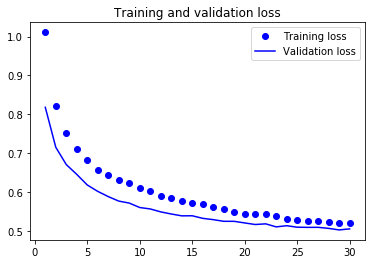

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [89]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.GRU(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/30
24128/24128 [==============================] - 9s 378us/step - loss: 0.9648 - acc: 0.6175 - val_loss: 0.7777 - val_acc: 0.7016
 val_f1_micro: 0.679086 | val_precision_micro: 0.785077 | val_recall_micro: 0.598309
Epoch 2/30
24128/24128 [==============================] - 8s 324us/step - loss: 0.7829 - acc: 0.6962 - val_loss: 0.7041 - val_acc: 0.7354
 val_f1_micro: 0.716297 | val_precision_micro: 0.804964 | val_recall_micro: 0.645225
Epoch 3/30
24128/24128 [==============================] - 8s 320us/step - loss: 0.7185 - acc: 0.7239 - val_loss: 0.6489 - val_acc: 0.7505
 val_f1_micro: 0.743484 | val_precision_micro: 0.789856 | val_recall_micro: 0.702255
Epoch 4/30
24128/24128 [==============================] - 8s 324us/step - loss: 0.6817 - acc: 0.7413 - val_loss: 0.6253 - val_acc: 0.7689
 val_f1_micro: 0.759340 | val_precision_micro: 0.821532 | val_recall_micro: 0.705902
Epoch 5/30
24128/24128 [==============================] - 8

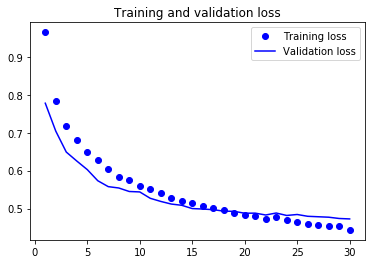

In [90]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [91]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/30
24128/24128 [==============================] - 11s 451us/step - loss: 0.9706 - acc: 0.6054 - val_loss: 0.8048 - val_acc: 0.6824
 val_f1_micro: 0.661042 | val_precision_micro: 0.739737 | val_recall_micro: 0.597480
Epoch 2/30
24128/24128 [==============================] - 10s 400us/step - loss: 0.8174 - acc: 0.6776 - val_loss: 0.7261 - val_acc: 0.7167
 val_f1_micro: 0.700628 | val_precision_micro: 0.763189 | val_recall_micro: 0.647546
Epoch 3/30
24128/24128 [==============================] - 10s 404us/step - loss: 0.7575 - acc: 0.7040 - val_loss: 0.6946 - val_acc: 0.7275
 val_f1_micro: 0.717420 | val_precision_micro: 0.772823 | val_recall_micro: 0.669430
Epoch 4/30
24128/24128 [==============================] - 10s 403us/step - loss: 0.7098 - acc: 0.7255 - val_loss: 0.6757 - val_acc: 0.7359
 val_f1_micro: 0.725133 | val_precision_micro: 0.791642 | val_recall_micro: 0.668932
Epoch 5/30
24128/24128 [==============================]

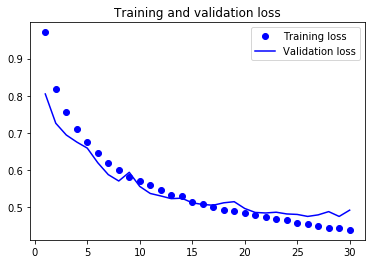

In [92]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

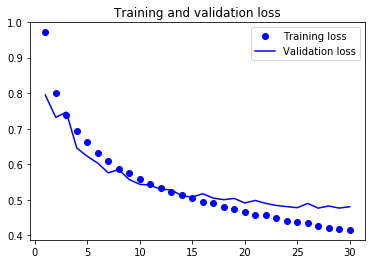

In [95]:
# Biderectional LSTM(64)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [96]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/30
24128/24128 [==============================] - 18s 736us/step - loss: 1.0313 - acc: 0.5799 - val_loss: 0.8285 - val_acc: 0.6744
 val_f1_micro: 0.646021 | val_precision_micro: 0.744377 | val_recall_micro: 0.570623
Epoch 2/30
24128/24128 [==============================] - 15s 610us/step - loss: 0.8340 - acc: 0.6706 - val_loss: 0.7633 - val_acc: 0.7062
 val_f1_micro: 0.675848 | val_precision_micro: 0.777036 | val_recall_micro: 0.597977
Epoch 3/30
24128/24128 [==============================] - 13s 526us/step - loss: 0.7709 - acc: 0.7001 - val_loss: 0.7007 - val_acc: 0.7263
 val_f1_micro: 0.715478 | val_precision_micro: 0.779777 | val_recall_micro: 0.660975
Epoch 4/30
24128/24128 [==============================] - 15s 615us/step - loss: 0.7312 - acc: 0.7158 - val_loss: 0.6681 - val_acc: 0.7445
 val_f1_micro: 0.734564 | val_precision_micro: 0.790076 | val_recall_micro: 0.686340
Epoch 5/30
24128/24128 [==============================]

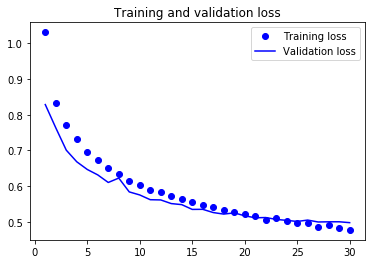

In [97]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [98]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.GRU(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=45,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/45
24128/24128 [==============================] - 10s 407us/step - loss: 0.9720 - acc: 0.6093 - val_loss: 0.7746 - val_acc: 0.6960
 val_f1_micro: 0.676730 | val_precision_micro: 0.760762 | val_recall_micro: 0.609416
Epoch 2/45
24128/24128 [==============================] - 8s 322us/step - loss: 0.7764 - acc: 0.6965 - val_loss: 0.6875 - val_acc: 0.7367
 val_f1_micro: 0.726872 | val_precision_micro: 0.776522 | val_recall_micro: 0.683190
Epoch 3/45
24128/24128 [==============================] - 8s 326us/step - loss: 0.7016 - acc: 0.7292 - val_loss: 0.6350 - val_acc: 0.7596
 val_f1_micro: 0.750395 | val_precision_micro: 0.797908 | val_recall_micro: 0.708223
Epoch 4/45
24128/24128 [==============================] - 8s 324us/step - loss: 0.6647 - acc: 0.7466 - val_loss: 0.6134 - val_acc: 0.7646
 val_f1_micro: 0.759003 | val_precision_micro: 0.794203 | val_recall_micro: 0.726790
Epoch 5/45
24128/24128 [==============================] - 

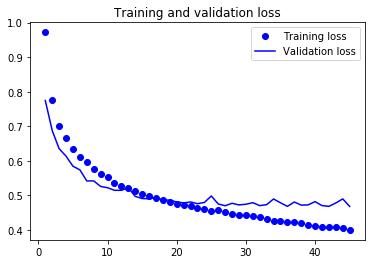

In [99]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [102]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.GRU(64, dropout=0.2, recurrent_dropout=0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/50
24128/24128 [==============================] - 10s 409us/step - loss: 1.0035 - acc: 0.5971 - val_loss: 0.7703 - val_acc: 0.7026
 val_f1_micro: 0.677313 | val_precision_micro: 0.781487 | val_recall_micro: 0.597646
Epoch 2/50
24128/24128 [==============================] - 7s 281us/step - loss: 0.8043 - acc: 0.6862 - val_loss: 0.6915 - val_acc: 0.7311
 val_f1_micro: 0.715824 | val_precision_micro: 0.796184 | val_recall_micro: 0.650199
Epoch 3/50
24128/24128 [==============================] - 7s 280us/step - loss: 0.7341 - acc: 0.7181 - val_loss: 0.6322 - val_acc: 0.7548
 val_f1_micro: 0.748408 | val_precision_micro: 0.802352 | val_recall_micro: 0.701260
Epoch 4/50
24128/24128 [==============================] - 7s 281us/step - loss: 0.7001 - acc: 0.7357 - val_loss: 0.6113 - val_acc: 0.7667
 val_f1_micro: 0.756337 | val_precision_micro: 0.809299 | val_recall_micro: 0.709881
Epoch 5/50
24128/24128 [==============================] - 

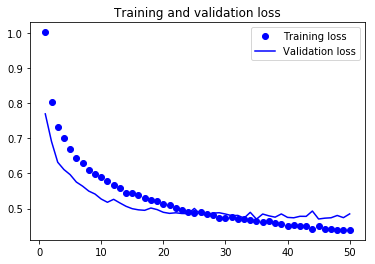

In [103]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [105]:
def get_embedding_matrix(emb_dir, emb_filename, word_index, max_words):
    
    embeddings_index = {}
    f = open(os.path.join(emb_dir, emb_filename), encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    embedding_dim = len(coefs)

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [106]:
glove_dir = r'D:\Machine Learning\Embeddings\glove.twitter.27B'
glove_file = 'glove.twitter.27B.100d.txt'
embedding_matrix_100d = get_embedding_matrix(glove_dir, glove_file,
                                             tokenizer.word_index, max_words)

Found 1193514 word vectors.


In [109]:
model = Sequential()
model.add(layers.Embedding(max_words, 100, input_length=maxlen))
model.add(layers.GRU(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix_100d])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/30
24128/24128 [==============================] - 10s 427us/step - loss: 0.8529 - acc: 0.6689 - val_loss: 0.6688 - val_acc: 0.7507
 val_f1_micro: 0.736134 | val_precision_micro: 0.802544 | val_recall_micro: 0.679874
Epoch 2/30
24128/24128 [==============================] - 8s 323us/step - loss: 0.6657 - acc: 0.7440 - val_loss: 0.6074 - val_acc: 0.7696
 val_f1_micro: 0.766733 | val_precision_micro: 0.795791 | val_recall_micro: 0.739721
Epoch 3/30
24128/24128 [==============================] - 8s 322us/step - loss: 0.6086 - acc: 0.7732 - val_loss: 0.5524 - val_acc: 0.7986
 val_f1_micro: 0.795686 | val_precision_micro: 0.829615 | val_recall_micro: 0.764423
Epoch 4/30
24128/24128 [==============================] - 8s 321us/step - loss: 0.5718 - acc: 0.7878 - val_loss: 0.5372 - val_acc: 0.8100
 val_f1_micro: 0.805763 | val_precision_micro: 0.845537 | val_recall_micro: 0.769562
Epoch 5/30
24128/24128 [==============================] - 

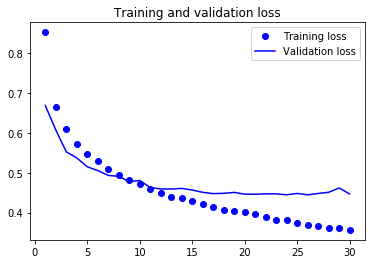

In [111]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [113]:
model = Sequential()
model.add(layers.Embedding(max_words, 100, input_length=maxlen))
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix_100d])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=45,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/45
24128/24128 [==============================] - 10s 411us/step - loss: 0.9381 - acc: 0.6321 - val_loss: 0.7144 - val_acc: 0.7273
 val_f1_micro: 0.715343 | val_precision_micro: 0.785063 | val_recall_micro: 0.656996
Epoch 2/45
24128/24128 [==============================] - 8s 329us/step - loss: 0.7000 - acc: 0.7305 - val_loss: 0.6177 - val_acc: 0.7691
 val_f1_micro: 0.763063 | val_precision_micro: 0.808270 | val_recall_micro: 0.722646
Epoch 3/45
24128/24128 [==============================] - 8s 340us/step - loss: 0.6311 - acc: 0.7609 - val_loss: 0.5793 - val_acc: 0.7833
 val_f1_micro: 0.778496 | val_precision_micro: 0.810404 | val_recall_micro: 0.749005
Epoch 4/45
24128/24128 [==============================] - 8s 334us/step - loss: 0.5995 - acc: 0.7730 - val_loss: 0.5523 - val_acc: 0.7981
 val_f1_micro: 0.796509 | val_precision_micro: 0.831799 | val_recall_micro: 0.764092
Epoch 5/45
24128/24128 [==============================] - 

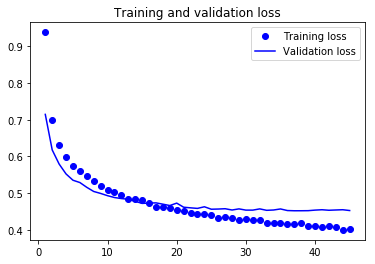

In [114]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [115]:

model = Sequential()
model.add(layers.Embedding(max_words, 100, input_length=maxlen))
model.add(layers.GRU(32, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix_100d])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=45,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/45
24128/24128 [==============================] - 11s 466us/step - loss: 1.0509 - acc: 0.5749 - val_loss: 0.7704 - val_acc: 0.7095
 val_f1_micro: 0.687287 | val_precision_micro: 0.772718 | val_recall_micro: 0.618866
Epoch 2/45
24128/24128 [==============================] - 8s 348us/step - loss: 0.7950 - acc: 0.6965 - val_loss: 0.6397 - val_acc: 0.7583
 val_f1_micro: 0.751392 | val_precision_micro: 0.804656 | val_recall_micro: 0.704741
Epoch 3/45
24128/24128 [==============================] - 8s 347us/step - loss: 0.7154 - acc: 0.7299 - val_loss: 0.6019 - val_acc: 0.7719
 val_f1_micro: 0.769605 | val_precision_micro: 0.808134 | val_recall_micro: 0.734582
Epoch 4/45
24128/24128 [==============================] - 9s 370us/step - loss: 0.6825 - acc: 0.7428 - val_loss: 0.5740 - val_acc: 0.7891
 val_f1_micro: 0.781089 | val_precision_micro: 0.825910 | val_recall_micro: 0.740882
Epoch 5/45
24128/24128 [==============================] - 

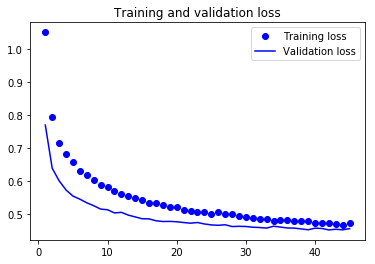

In [116]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [120]:

model = Sequential()
model.add(layers.Embedding(max_words, 100, input_length=maxlen))
model.add(layers.GRU(32, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix_100d])
model.layers[0].trainable = False
model.compile(optimizer=RMSprop(lr=0.01),
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/20
24128/24128 [==============================] - 10s 424us/step - loss: 0.7823 - acc: 0.7015 - val_loss: 0.5759 - val_acc: 0.7898
 val_f1_micro: 0.786772 | val_precision_micro: 0.823338 | val_recall_micro: 0.753316
Epoch 2/20
24128/24128 [==============================] - 8s 343us/step - loss: 0.6335 - acc: 0.7680 - val_loss: 0.5360 - val_acc: 0.8057
 val_f1_micro: 0.799201 | val_precision_micro: 0.839693 | val_recall_micro: 0.762434
Epoch 3/20
24128/24128 [==============================] - 8s 342us/step - loss: 0.5925 - acc: 0.7846 - val_loss: 0.5077 - val_acc: 0.8198
 val_f1_micro: 0.820129 | val_precision_micro: 0.852315 | val_recall_micro: 0.790285
Epoch 4/20
24128/24128 [==============================] - 8s 346us/step - loss: 0.5751 - acc: 0.7931 - val_loss: 0.4970 - val_acc: 0.8249
 val_f1_micro: 0.820215 | val_precision_micro: 0.859557 | val_recall_micro: 0.784317
Epoch 5/20
24128/24128 [==============================] - 

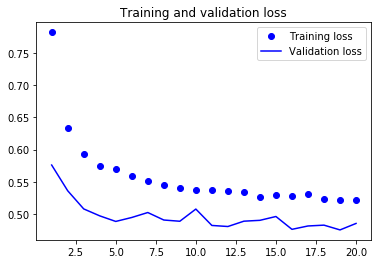

In [121]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [122]:
model = Sequential()
model.add(layers.Embedding(max_words, 100, input_length=maxlen))
model.add(layers.GRU(32, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix_100d])
model.layers[0].trainable = False
model.compile(optimizer=RMSprop(lr=0.006),
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/20
24128/24128 [==============================] - 11s 445us/step - loss: 0.8103 - acc: 0.6871 - val_loss: 0.5827 - val_acc: 0.7846
 val_f1_micro: 0.773380 | val_precision_micro: 0.825711 | val_recall_micro: 0.727288
Epoch 2/20
24128/24128 [==============================] - 8s 330us/step - loss: 0.6411 - acc: 0.7614 - val_loss: 0.5362 - val_acc: 0.8077
 val_f1_micro: 0.800976 | val_precision_micro: 0.844641 | val_recall_micro: 0.761605
Epoch 3/20
24128/24128 [==============================] - 8s 330us/step - loss: 0.5964 - acc: 0.7822 - val_loss: 0.5381 - val_acc: 0.8123
 val_f1_micro: 0.810999 | val_precision_micro: 0.833567 | val_recall_micro: 0.789622
Epoch 4/20
24128/24128 [==============================] - 8s 323us/step - loss: 0.5752 - acc: 0.7906 - val_loss: 0.4967 - val_acc: 0.8239
 val_f1_micro: 0.818401 | val_precision_micro: 0.850125 | val_recall_micro: 0.788959
Epoch 5/20
24128/24128 [==============================] - 

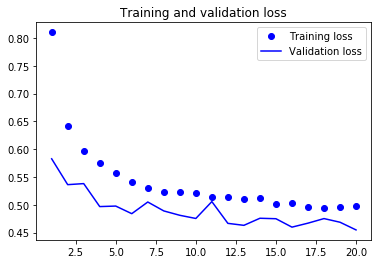

In [123]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [124]:
glove_dir = r'D:\Machine Learning\Embeddings\glove.twitter.27B'
glove_file = 'glove.twitter.27B.200d.txt'
embedding_matrix_200d = get_embedding_matrix(glove_dir, glove_file,
                                             tokenizer.word_index, max_words)

Found 1193514 word vectors.


In [125]:
model = Sequential()
model.add(layers.Embedding(max_words, 200, input_length=maxlen))
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix_200d])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/30
24128/24128 [==============================] - 10s 434us/step - loss: 0.8574 - acc: 0.6698 - val_loss: 0.6467 - val_acc: 0.7583
 val_f1_micro: 0.747630 | val_precision_micro: 0.802739 | val_recall_micro: 0.699602
Epoch 2/30
24128/24128 [==============================] - 7s 297us/step - loss: 0.6225 - acc: 0.7662 - val_loss: 0.5752 - val_acc: 0.7835
 val_f1_micro: 0.781330 | val_precision_micro: 0.806565 | val_recall_micro: 0.757626
Epoch 3/30
24128/24128 [==============================] - 7s 304us/step - loss: 0.5682 - acc: 0.7896 - val_loss: 0.5293 - val_acc: 0.8115
 val_f1_micro: 0.806163 | val_precision_micro: 0.838346 | val_recall_micro: 0.776359
Epoch 4/30
24128/24128 [==============================] - 8s 314us/step - loss: 0.5360 - acc: 0.8033 - val_loss: 0.5137 - val_acc: 0.8193
 val_f1_micro: 0.818706 | val_precision_micro: 0.851945 | val_recall_micro: 0.787964
Epoch 5/30
24128/24128 [==============================] - 

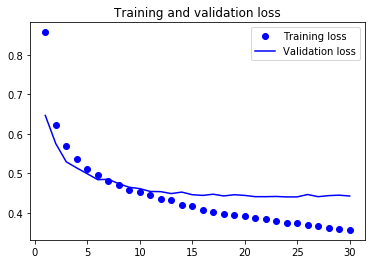

In [126]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [128]:
model = Sequential()
model.add(layers.Embedding(max_words, 200, input_length=maxlen))
model.add(layers.GRU(32, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix_200d])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train,
                    epochs=45,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 24128 samples, validate on 6032 samples
Epoch 1/45
24128/24128 [==============================] - 10s 414us/step - loss: 0.9891 - acc: 0.6096 - val_loss: 0.7117 - val_acc: 0.7293
 val_f1_micro: 0.715030 | val_precision_micro: 0.779867 | val_recall_micro: 0.660146
Epoch 2/45
24128/24128 [==============================] - 7s 293us/step - loss: 0.7287 - acc: 0.7282 - val_loss: 0.6027 - val_acc: 0.7722
 val_f1_micro: 0.770314 | val_precision_micro: 0.809498 | val_recall_micro: 0.734748
Epoch 3/45
24128/24128 [==============================] - 8s 320us/step - loss: 0.6475 - acc: 0.7615 - val_loss: 0.5596 - val_acc: 0.7933
 val_f1_micro: 0.790818 | val_precision_micro: 0.824694 | val_recall_micro: 0.759615
Epoch 4/45
24128/24128 [==============================] - 7s 305us/step - loss: 0.6118 - acc: 0.7774 - val_loss: 0.5298 - val_acc: 0.8074
 val_f1_micro: 0.803320 | val_precision_micro: 0.839386 | val_recall_micro: 0.770225
Epoch 5/45
24128/24128 [==============================] - 

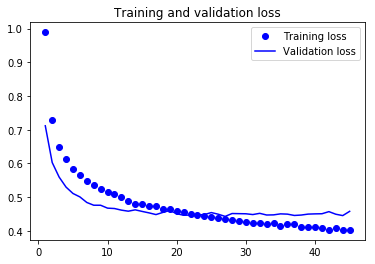

In [129]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()